In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', 500)

In [2]:
sub = xr.open_dataset('../data/netcdfs/banner_lowman_05208_21019-019_21021-007_0006d.nc')

In [3]:
sub = sub.coarsen(x=4, boundary = 'trim').mean().coarsen(y=4, boundary = 'trim').mean()

for name, values in sub.items():
    if name != 'dem':
        sub[name] = sub[name].where(sub['dem'] != -10000.0)
sub['dem'] = sub['dem'].where(sub['dem'] != -10000.0)

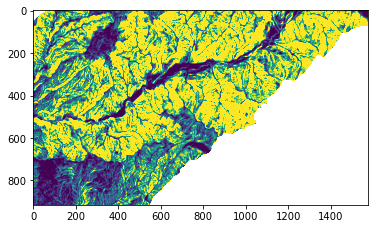

In [6]:
plt.imshow(sub['focal_var'], vmin = 0.8, vmax = 15)

In [ ]:
col = 'lithography'

da = sub[col]
vmin_val = np.nanmean(da) - np.nanstd(da)
vmax_val = np.nanmean(da) + np.nanstd(da)
plt.imshow(da, vmin = vmin_val, vmax = vmax_val)
plt.colorbar()

In [ ]:
c = data.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")

print(so[:110])

## Make Data

In [8]:
y = sub['VV-cor'].values.ravel() #[100:3000,100:2700]

ls = ['trees','slope','dem','focal_var','tmean','inc','ppt_total','focal_var','land_forms','land_class']
data = pd.DataFrame()
for var in ls:
    x = sub[var].values.ravel() #[100:3000,100:2700]
    x = x[~np.isnan(y)]

    data[var] = x

x = sub['aspect'].values.ravel() #[100:3000,100:2700]
x = x[~np.isnan(y)]

data['easting'] = np.cos(x)
data['northing'] = np.sin(x)

y = y[~np.isnan(y)]
data['target'] = y

## Build Pipelines

In [9]:
categorical_features = ['land_forms','land_class','target']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

numeric_features = data.columns.drop(categorical_features)
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())])

categorical_features.pop(-1)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)])

## Window

In [ ]:
from math import floor,ceil
shape = sub['VV-cor'].shape
x_range = 4
y_range = 4
for x_quad in range(x_range):
    for y_quad in range(y_range):
        x_start = floor(x_quad*shape[0]/x_range)
        x_end = floor(x_quad*shape[0]/x_range+shape[0]/x_range)
        y_start = floor(y_quad*shape[1]/y_range)
        y_end = floor(y_quad*shape[1]/y_range+shape[1]/y_range)
        
        print(x_start,x_end,y_start,y_end)
        
        y = sub['VV-cor'][x_start:x_end,y_start:y_end].values.ravel() #[100:3000,100:2700]
        if np.count_nonzero(~np.isnan(y)) >0:
            
            ls = ['trees','slope','dem','focal_var','tmean','inc','ppt_total','focal_var','land_forms','land_class']
            data = pd.DataFrame()
            for var in ls:
                x = sub[var][x_start:x_end,y_start:y_end].values.ravel() #[100:3000,100:2700]
                x = x[~np.isnan(y)]

                data[var] = x

            x = sub['aspect'][x_start:x_end,y_start:y_end].values.ravel() #[100:3000,100:2700]
            x = x[~np.isnan(y)]

            data['easting'] = np.cos(x)
            data['northing'] = np.sin(x)

            y = y[~np.isnan(y)]
            data['target'] = y

            y = data.target
            X = data.drop(['target'],axis = 1)


            lr_pipe = Pipeline([
                ('preprocess', preprocessor),
                ('classify', Ridge(fit_intercept=False))
            ])

            lr_pipe.fit(X,y)

            preds = lr_pipe.predict(X)

            print(f'R2: {r2_score(y, preds)}')
    #         for i in range(len(X.columns)):
    #             print(X.columns[i])
    #             print(lr_pipe.named_steps['classify'].coef_[i])

In [ ]:
plt.imshow(sub['VV-cor'][915:1830,0:1576])

In [ ]:
x_start = floor(x_quad*shape[0]/x_range)
x_end = floor(x_quad*shape[0]/x_range+shape[0]/x_range)
y_start = floor(y_quad*shape[1]/y_range)
y_end = floor(y_quad*shape[1]/y_range+shape[1]/y_range)

print(x_start,x_end,y_start,y_end)

y = sub['VV-cor'][915:1830,0:1576].values.ravel() #[100:3000,100:2700]
if np.count_nonzero(~np.isnan(y)) >0:

    ls = ['trees','slope','dem','focal_var','tmean','inc','ppt_total','focal_var','land_forms','land_class']
    data = pd.DataFrame()
    for var in ls:
        x = sub[var][915:1830,0:1576].values.ravel() #[100:3000,100:2700]
        x = x[~np.isnan(y)]

        data[var] = x

    x = sub['aspect'][915:1830,0:1576].values.ravel() #[100:3000,100:2700]
    x = x[~np.isnan(y)]

    data['easting'] = np.cos(x)
    data['northing'] = np.sin(x)

    y = y[~np.isnan(y)]
    data['target'] = y

    y = data.target
    X = data.drop(['target'],axis = 1)


    lr_pipe = Pipeline([
        ('preprocess', preprocessor),
        ('classify', Ridge(fit_intercept=False))
    ])

    lr_pipe.fit(X,y)

    preds = lr_pipe.predict(X)

    print(f'R2: {r2_score(y, preds)}')
    for i in range(len(X.columns)):
        print(X.columns[i])
        print(lr_pipe.named_steps['classify'].coef_[i])

plt.imshow(sub['VV-cor'][915:1830,0:1576])
plt.colorbar()
plt.show()
plt.imshow(preds.reshape(1830-915,1576))
plt.colorbar()
plt.show()
plt.show()
plt.imshow(sub['VV-cor'][915:1830,0:1576]-preds.reshape(1830-915,1576))
plt.colorbar()
plt.show()

In [ ]:
win_rows, win_cols = 5, 5

img = sub['trees'][915:1830,0:1576].values
win_mean = ndimage.uniform_filter(img, (win_rows, win_cols))
win_sqr_mean = ndimage.uniform_filter(img**2, (win_rows, win_cols))
win_var = win_sqr_mean - win_mean**2
plt.imshow(win_var)

In [ ]:
plt.imshow(sub['VV-cor'][915:1830,0:1576])
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(sub['ppt_total'][915:1830,0:1576])
plt.colorbar()
plt.show()

## Linear Regression

In [10]:
y = data.target
X = data.drop(['target'],axis = 1)


lr_pipe = Pipeline([
    ('preproc', preprocessor),
    ('classify', Ridge(fit_intercept=False))
])

lr_pipe.fit(X,y)

preds = lr_pipe.predict(X)

print('R2')
print(r2_score(y, preds))
for i in range(len(X.columns)):
    print(X.columns[i])
    print(lr_pipe.named_steps['classify'].coef_[i])

R2
0.05080168011980568
trees
-0.006153752232159699
slope
-0.005462277064951314
dem
0.004688981259359834
focal_var
0.0011170239711609997
tmean
0.06674177649145258
inc
0.00231171668873781
ppt_total
0.05808396097627388
land_forms
-0.00606900839096621
land_class
0.008479184969688308
easting
0.08375056427896418
northing
0.018447439169148806


## Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
y = data.target
X = data.drop(['target'],axis = 1)

br_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('classify', ElasticNet(alpha = 100, l1_ratio = 0.8, fit_intercept = True))
])

parameters = {'classify__alpha':[0.0001,0.001,0.01,0.1,1], 'classify__l1_ratio':[0.1,0.2,0.3,0.4, 0.5,0.75]}

search = GridSearchCV(br_pipe, cv = 2, parameters, verbose = 2)

search.fit(X, y)

## MLP Regressor

In [11]:
from sklearn.neural_network import MLPRegressor

y = data.target
X = data.drop(['target'],axis = 1)

mlr_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('classify', MLPRegressor(hidden_layer_sizes = (100,), activation = 'relu', alpha = 0.0001))
])


mlr_pipe.fit(X, y)

preds = mlr_pipe.predict(X)

print('R2')
print(r2_score(y, preds))

R2
0.3299007665219923


In [12]:
plt.imshow(data['target'].values.reshape((2900,2600)),vmax = 0.6,vmin = 0.4)
plt.colorbar()
plt.show()
pred = mlr_pipe.predict(X).reshape((2900,2600))
plt.imshow(pred,vmax = 0.6,vmin = 0.4)
plt.colorbar()
plt.show()
plt.imshow(pred-data['target'].values.reshape(2900,2600))
plt.colorbar()
plt.show()

ValueError: cannot reshape array of size 983720 into shape (2900,2600)

In [ ]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)